In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from numpy import array
import pickle
import nltk
nltk.download('punkt')
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import LSTM, CuDNNLSTM, Embedding, Dropout, Input, Dense
from keras.layers.merge import add

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Using TensorFlow backend.


In [0]:
# import tensorflow as tf
# import keras
# config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 1} ) 
# sess = tf.Session(config=config) 
# keras.backend.set_session(sess)

import tensorflow as tf
import os

tf.config.optimizer.set_jit(True)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


## RNNModel class functions

- init(): Initializes the class with the datapaths
- loadInputData(): Load all the pickled data files created before.
- readFiles(): Helper function to read pkl files.
- getMaxLengthDesc(): Get the length of the longest description.
- generateData(): Used to generate description data and image objects data to fit the model on. For each word in given description sentence, encoded tokens for first 1 to n-1 words are set as input whereas encoded token of nth word is set as output lable and remaining places are masked with 0.
- buildModel(): In this function, keras model layers are mentioned. Input to the model will be detected image objects data and generated captions data. The text caption data is passed through LSTM model. Finally, layers of image processing unit and text processing LSTM unit are merged and two dense layers are added before finalizing the model design. 
- trainModel(): The model is trained for number of epochs mentioned as a parameter. For each epochs, this function calls generateData() function for filling the inputs placeholder. For now, we have mentioned number of epochs = 10. However, the model will be trained on more epochs for the next submission.


In [0]:
class rnnModel:
    def __init__(self):
        self.dirPath = "/content/drive/My Drive/NLP_Project/ProjectCode"
        self.dataPath = "/content/drive/My Drive/NLP_Project/ProjectCode/dataset"
        self.imgPath = "/content/drive/My Drive/NLP_Project/ProjectCode/dataset/Flicker8k_Dataset"
        self.modelsPath = "/content/drive/My Drive/NLP_Project/ProjectCode/models"
        self.lstmModelsPath = "/content/drive/My Drive/NLP_Project/ProjectCode/models/lstmModels"
        self.descFile = "Flickr8k.token.txt"
        self.trainDataFile = "Flickr_8k.trainImages.txt"
        self.testDataFile = "Flickr_8k.testImages.txt"

    def loadInputData(self):
        self.tokens = self.readFiles("trainTokens.pkl")
        self.imageData = self.readFiles("imageObjects.pkl")
        self.descriptionData = self.readFiles("trainDescription.pkl")
        self.vocabulary = self.readFiles("trainVocabulary.pkl")

    def loadImgData(self,fileName):
        with open(fileName, 'rb') as f:
            inputData = pickle.load(f)
            return inputData

    def readFiles(self,fileName):
        with open(self.modelsPath+"/"+fileName, 'rb') as f:
            inputData = pickle.load(f)
            return inputData

    def getMaxLengthDesc(self):
        self.allDescriptionsLen = []
        self.allDescriptions = []

        for values in self.descriptionData.values():
            # add all the lengths of the descriptions
            self.allDescriptions.extend((nltk.word_tokenize(value)) for value in values)
            self.allDescriptionsLen.extend(len(nltk.word_tokenize(value)) for value in values)
            
        return max(self.allDescriptionsLen)
            
    def generateData(self):
        for key, values in self.descriptionData.items():
            input1, input2, outputLabels = [], [], []
            
            for value in values:
                encodedDescription = self.tokens.texts_to_sequences([value])[0]
                
                for n in range(1, len(encodedDescription)):
                    input = pad_sequences([encodedDescription[:n]], maxlen=self.maxLen)[0]
                    output = to_categorical([encodedDescription[n]], num_classes=self.vocabSize)[0]

                    input1.append(self.imageData[key][0])
                    input2.append(input)
                    outputLabels.append(output)
                    
            yield [[array(input1), array(input2)], array(outputLabels)]
            
    def buildModel(self):
        self.vocabSize = len(self.vocabulary) + 1
        self.maxLen = self.getMaxLengthDesc()
        
        input1 = Input(shape=(4096,))
        first = Dropout(0.5)(input1)
        second = Dense(256, activation='relu')(input1)
        
        # sequence model
        input2 = Input(shape=(self.maxLen,))
        layer1 = Embedding(self.vocabSize, 256, mask_zero=True)(input2)
        layer2 = Dropout(0.5)(layer1)
        layer3 = LSTM(256)(layer2)
        
        # decoder model
        final1 = add([second, layer3])
        final2 = Dense(256, activation='relu')(final1)
        output = Dense(self.vocabSize, activation='softmax')(final2)

        # tie it together [image, seq] [word]
        self.model = Model(inputs=[input1, input2], outputs=output)

        # compile model
        self.model.compile(loss='categorical_crossentropy', optimizer='adam')

        # summarize model
        self.model.summary()

    def trainModel(self, epochs):
        steps = len(self.descriptionData)
        
        for i in range(epochs):
            # fit for one epoch
            self.model.fit_generator(self.generateData(), epochs=1, steps_per_epoch=steps, verbose=1)
            
            self.model.save_weights(self.lstmModelsPath+"/LSTM_WEIGHTS_"+str(i)+".hdf5")
            self.model.save(self.lstmModelsPath+"/LSTM_MODEL_"+str(i)+".h5")
        print("done!")

Class object for rnnModel is created which is used for further operations on rnnModel.

In [0]:
rnnModel = rnnModel()
rnnModel.loadInputData()
rnnModel.buildModel()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 33)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 33, 256)      1860352     input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 4096)         0                                            
___________________________________________________________________________

In [0]:
# Training the rnnModel for 10 epochs
rnnModel.trainModel(10)




Epoch 1/1





6000/6000 [==============================] - 2259s 377ms/step - loss: 4.6558
Epoch 1/1
6000/6000 [==============================] - 2262s 377ms/step - loss: 3.9222
Epoch 1/1
6000/6000 [==============================] - 2249s 375ms/step - loss: 3.6655
Epoch 1/1
6000/6000 [==============================] - 2242s 374ms/step - loss: 3.5051
Epoch 1/1
6000/6000 [==============================] - 2239s 373ms/step - loss: 3.4050
Epoch 1/1
6000/6000 [==============================] - 2255s 376ms/step - loss: 3.3317
Epoch 1/1
6000/6000 [==============================] - 2255s 376ms/step - loss: 3.2749
Epoch 1/1
6000/6000 [==============================] - 2263s 377ms/step - loss: 3.2288
Epoch 1/1
6000/6000 [==============================] - 2254s 376ms/step - loss: 3.1910
Epoch 1/1
6000/6000 [==============================] - 2239s 373ms/step - loss: 3.1633
done!


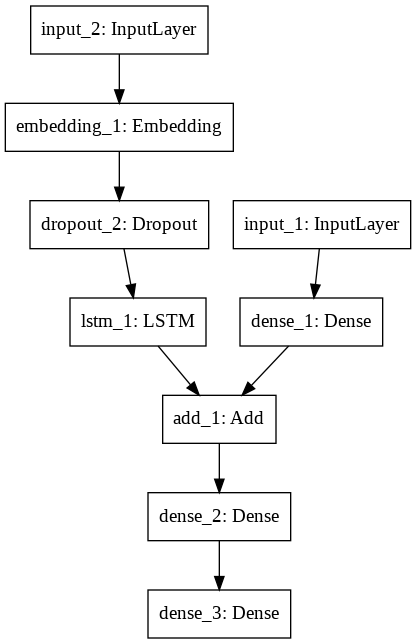

In [0]:
from keras.utils import plot_model
plot_model(rnnModel.model, to_file='model.png')

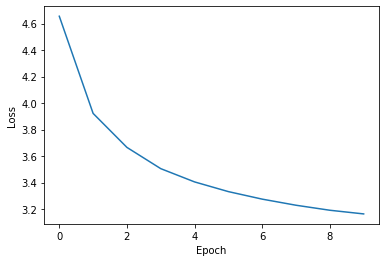

In [0]:
from matplotlib import pyplot as plt
plt.plot([4.6558,3.9222,3.6655,3.5051,3.4050,3.3317,3.2749,3.2288,3.1910,3.1633])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()